In [2]:
import gymnasium as gym
import torch
from Actor_Critic import A2C
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#Making vectorized environments, so that our model can simultaneously train on multiple environments

envs = gym.vector.SyncVectorEnv(
    [
        lambda: gym.make(
            "LunarLander-v3",
            gravity=-10.0,
            enable_wind=True,
            wind_power=15.0,
            turbulence_power=1.5,
            max_episode_steps=600,
        ),
        lambda: gym.make(
            "LunarLander-v3",
            gravity=-9.8,
            enable_wind=True,
            wind_power=10.0,
            turbulence_power=1.3,
            max_episode_steps=600,
        ),
        lambda: gym.make(
            "LunarLander-v3",
            gravity=-8.0,
            enable_wind=True,
            wind_power=12.0,
            turbulence_power=1.5,
            max_episode_steps=600,
        )
    ]
)

In [4]:
n_envs = 3  # since we declared three environments 
n_updates = 1000  # number of updates to run on the net
n_steps_per_update = 128  # number of steps to execute each update

gamma = 0.999  # discount factor for rewards
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.01  # entropy coefficient, controls the entropy term in the loss
actor_lr = 0.001 # actor learning rate
critic_lr = 0.005 # critic learning rate


obs_shape=envs.single_observation_space.shape[0]  # the observation space, i.e , n_features
action_shape=envs.single_action_space.n  # the action space , i.e , n_actions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # the device to run the computations on

agent=A2C(obs_shape,action_shape,device,critic_lr,actor_lr,n_envs)  # creating an instance of our A2C Class


In [5]:
envs_wrapper = gym.wrappers.vector.RecordEpisodeStatistics(
    envs, buffer_length=n_envs * n_updates
)  

critic_losses = []  # logging the losses for visualization
actor_losses = []
entropies = []

for sample_phase in tqdm.tqdm(range(n_updates)):

    ep_value_preds=torch.zeros(n_steps_per_update , n_envs , device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    if sample_phase==0:
        states , info = envs_wrapper.reset(seed=42)


    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(
            states
        )

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = envs_wrapper.step(
            actions.cpu().numpy()
        )

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor([not term for term in terminated])

    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        lam,
        ent_coef,
        device,
    )

    agent.update_parameters(critic_loss, actor_loss)
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())




100%|██████████| 1000/1000 [02:27<00:00,  6.77it/s]


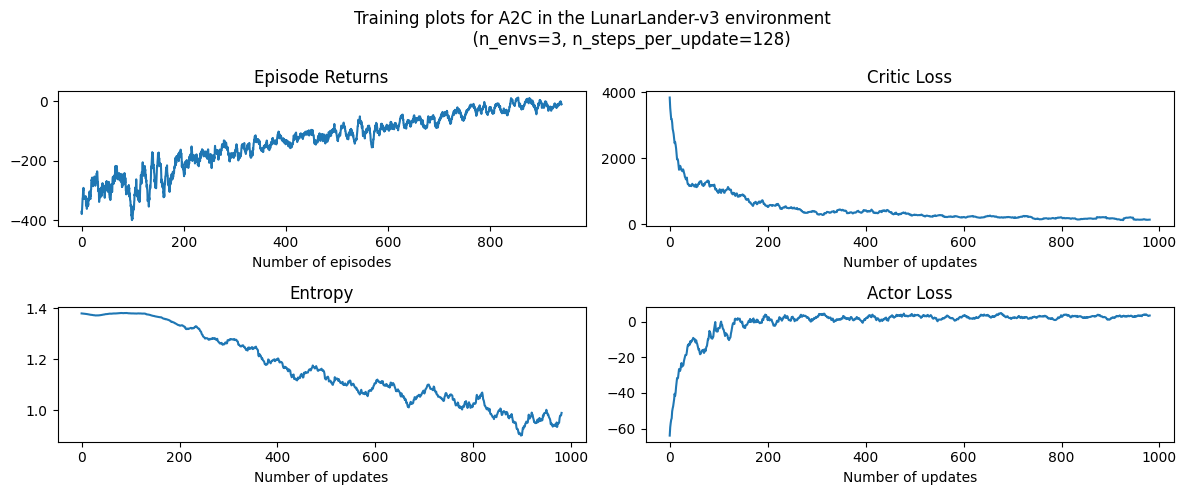

In [6]:
rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the LunarLander-v3 environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [7]:
save_weights = False
load_weights = False

actor_weights_path = "weights/actor_weights.h5"
critic_weights_path = "weights/critic_weights.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

In [8]:
n_showcase_episodes = 10



for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    episode_reward=0.0
    
    env = gym.make("LunarLander-v3", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :])

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())
        episode_reward+=reward

        # update if the environment is done
        done = terminated or truncated

    print(episode_reward)
env.close()

starting episode 0...
-23.72430739096737
starting episode 1...
64.23560575937267
starting episode 2...
-31.36122084629511
starting episode 3...
5.493925785673127
starting episode 4...
-28.28453987920176
starting episode 5...
8.028920469282326
starting episode 6...
-29.37899740431078
starting episode 7...
4.262872415228415
starting episode 8...
14.96176250150279
starting episode 9...
29.878980410055902


Inference from the model's performance:

🤖The model learned to avoid crash landings as crashing gives a negative reward of -100. If you rerun the code , you'll see that the agent , even though deviates from the original landing spot , still focuses more on avoiding a crash landing